In [1]:
import pandas as pd
import numpy as np
import skimpy as sk

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

#Catboost
from catboost import CatBoostRegressor

#Sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

#SkForecast
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.preprocessing import TimeSeriesDifferentiator

In [2]:
df= pd.read_csv("/Users/santi/Documents/csv/datos_arreglados.csv",sep=",",index_col=0)

df["date"]=pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

df.head(5)

,item,category,department,stores,region,week,year,is_holidays,units_sold,sell_price,total_sales
date,,,,,,,,,,,
2013-07-08,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,0,0,12.7414,0.0000
2013-07-15,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,1,0,12.7414,0.0000
2013-07-22,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,29,2013,0,4,10.9858,43.9432
2013-07-29,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,30,2013,0,6,10.9858,65.9148
2013-08-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,31,2013,0,0,10.9858,0.0000


In [3]:
sk.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 6610513 │ │ string      │ 5     │                                                         │
│ │ Number of columns │ 11      │ │ int64       │ 4     │                                                         │
│ └───────────────────┴─────────┘ │ float64     │ 2     │                                                         │
│                                 └─────────────┴───────┘                                                         │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA   ┃ NA %   ┃ mean   ┃ sd     ┃ p0      ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ week             │    0 │      0 │     26 │     15 │       1 │     12 │     25 │     39 │     52 │ ▇▇▇▆▇▇  │  │
│ │ year             │    0 │      0 │   2000 │    1.5 │    2000 │   2000 │   2000 │   2000 │   2000 │ ▃▅▇▇▇▃  │  │
│ │ is_holidays      │    0 │      0 │   0.25 │   0.44 │       0 │      0 │      0 │      1 │      1 │ ▇    ▃  │  │
│ │ units_sold       │    0 │      0 │    9.9 │     26 │       0 │      1 │      3 │     10 │   4200 │    ▇    │  │
│ │ sell_price       │    0 │      0 │    5.5 │    4.4 │   0.012 │    2.6 │    4.2 │    7.2 │    130 │    ▇    │  │
│ │ total_sales      │    0 │      0 │     35 │     77 │       0 │    1.2 │     15 │     39 │   7500 │    ▇    │  │
│ └──────────────────┴──────┴────────┴────────┴────────┴─────────┴────────┴────────┴────────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ item                      │       0 │          0 │                            1 │                  6610513 │  │
│ │ category                  │       0 │          0 │                            1 │                  6610513 │  │
│ │ department                │       0 │          0 │                            1 │                  6610513 │  │
│ │ stores                    │       0 │          0 │                            1 │                  6610513 │  │
│ │ region                    │       0 │          0 │                          1.4 │                  9227055 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [4]:
(df.index.max(),df.index.min())

(Timestamp('2016-04-25 00:00:00'), Timestamp('2011-01-31 00:00:00'))

In [5]:
# Agrupar por semana y luego por ítem, sumando las ventas totales
df_productos = df.groupby([pd.Grouper(freq='W'), 'item'])['total_sales'].sum().reset_index()
df_productos.head()


,date,item,total_sales
0,2011-02-06,ACCESORIES_1_004,40.4054
1,2011-02-06,ACCESORIES_1_008,35.0056
2,2011-02-06,ACCESORIES_1_009,31.1220
3,2011-02-06,ACCESORIES_1_010,21.0805
4,2011-02-06,ACCESORIES_1_012,23.8602


In [6]:
df_productos_multi = pd.pivot_table(
           data    = df_productos,
           values  = 'total_sales',
           index   = 'date',
           columns = 'item'
       )

df_productos_multi = df_productos_multi.asfreq('1W')

In [7]:
df_productos_multi.tail(10)

item,ACCESORIES_1_001,ACCESORIES_1_002,ACCESORIES_1_003,ACCESORIES_1_004,ACCESORIES_1_005,ACCESORIES_1_006,ACCESORIES_1_007,ACCESORIES_1_008,ACCESORIES_1_009,ACCESORIES_1_010,...,SUPERMARKET_3_818,SUPERMARKET_3_819,SUPERMARKET_3_820,SUPERMARKET_3_821,SUPERMARKET_3_822,SUPERMARKET_3_823,SUPERMARKET_3_824,SUPERMARKET_3_825,SUPERMARKET_3_826,SUPERMARKET_3_827
date,,,,,,,,,,,,,,,,,,,,,
2016-02-28,395.4888,116.1622,63.2016,746.7152,265.7340,77.8848,262.0100,180.6672,105.3094,150.1038,...,783.144,225.720,399.168,340.632,845.352,321.408,5.952,372.528,99.840,384.0
2016-03-06,373.5172,89.7617,67.1517,777.5712,266.1330,81.7152,293.4512,169.8144,124.5146,142.2036,...,775.992,211.464,297.000,297.132,802.368,387.072,0.000,300.888,124.416,290.4
2016-03-13,406.4746,121.4423,98.7525,610.9488,326.0229,72.7776,199.1276,100.2288,131.5769,114.5529,...,775.992,258.984,332.640,298.800,780.936,248.832,0.000,396.408,147.456,369.6
2016-03-20,417.4604,73.9214,59.2515,715.8592,303.8385,85.5456,199.1276,208.7568,70.5565,130.3533,...,804.600,211.464,289.872,382.464,883.560,278.928,0.000,391.632,139.776,286.8
2016-03-27,439.4320,89.7617,67.1517,685.0032,307.6689,66.3936,220.0884,155.7696,0.0000,130.3533,...,815.328,209.088,285.120,322.704,788.040,32.184,0.000,291.336,145.920,199.2
2016-04-03,582.4070,105.6020,75.0519,752.8864,303.8385,79.1616,209.6080,83.6304,4.3358,130.3533,...,944.064,235.224,335.016,340.632,883.560,0.000,0.000,281.784,147.456,220.8
2016-04-10,428.6058,89.7617,67.1517,666.4896,265.7340,72.7776,115.2844,215.1408,166.5160,173.8044,...,668.712,228.096,332.640,316.728,822.792,0.000,133.296,334.320,125.952,207.6
2016-04-17,351.8648,68.6413,63.2016,734.3728,265.7340,72.7776,251.5296,176.8368,140.9933,154.0539,...,486.336,263.736,320.760,298.800,907.656,25.032,83.328,448.944,155.136,238.8
2016-04-24,310.9540,95.0418,114.5529,722.0304,188.9265,67.6704,230.5688,166.6224,139.3840,146.1537,...,328.992,268.488,346.896,340.632,1022.064,296.808,104.160,396.408,118.272,201.6


In [8]:
df_productos_multi.fillna(0,inplace=True)

In [9]:
idx_punto_corte = int(len(df_productos_multi) * 0.6)
punto_corte=df_productos_multi [:idx_punto_corte].index.max()
print(punto_corte)
idx_punto_corte_test = int(len(df_productos_multi) * 0.8)
punto_corte_test=df_productos_multi [:idx_punto_corte_test].index.max()
print(punto_corte_test)


2014-03-23 00:00:00
2015-04-12 00:00:00


In [10]:
end_train = '2014-04-13 00:00:00'
end_val = '2015-05-10 00:00:00'

data_train = df_productos_multi.loc[:end_train, :].copy()
data_val   = df_productos_multi.loc[end_train:end_val, :].copy()
data_test  = df_productos_multi.loc[end_val:, :].copy()

print(f"Fechas train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Fechas validación : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Fechas test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Fechas train      : 2011-02-06 00:00:00 --- 2014-04-13 00:00:00  (n=167)
Fechas validación : 2014-04-13 00:00:00 --- 2015-05-10 00:00:00  (n=57)
Fechas test       : 2015-05-10 00:00:00 --- 2016-05-01 00:00:00  (n=52)


/var/folders/h2/m__59kjn7y17pxmn41zlkfsm0000gn/T/ipykernel_956/182488045.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_productos_multi.iloc[:, [20,50,70,90,110,130]].plot(


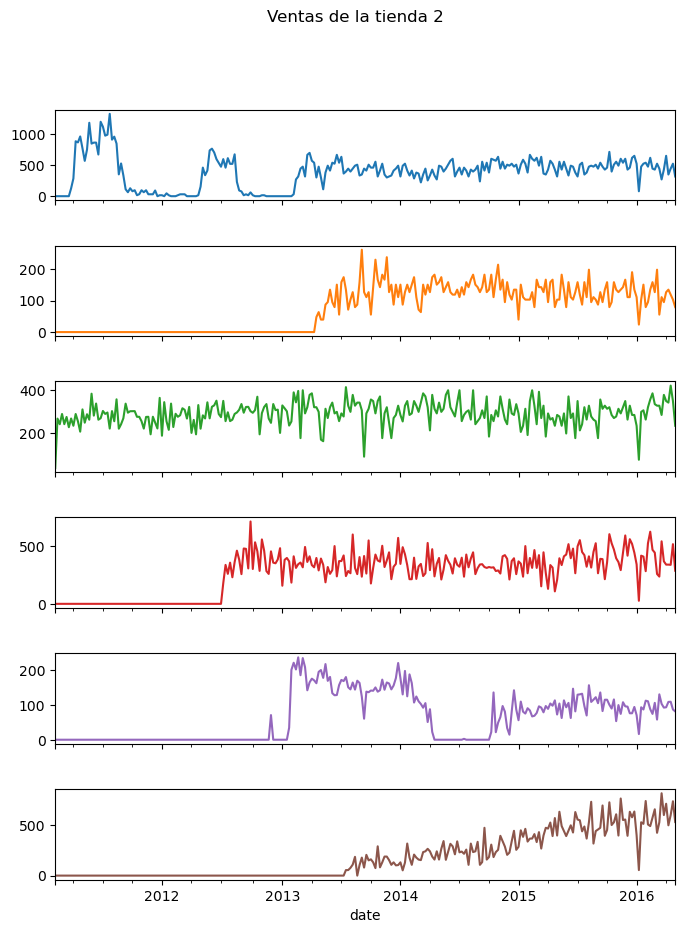

In [11]:
import random
fig, ax = plt.subplots(figsize=(8, 10))
df_productos_multi.iloc[:, [20,50,70,90,110,130]].plot(
    legend   = False,
    subplots = True, 
    sharex   = True,
    title    = 'Ventas de la tienda 2',
    ax       = ax,   # Define el diseño de los subplots (5 filas, 4 columnas)    # Añade espacio vertical entre los subplots
)

plt.subplots_adjust(hspace=0.5)  # Ajusta el espacio vertical entre subplots

plt.show()

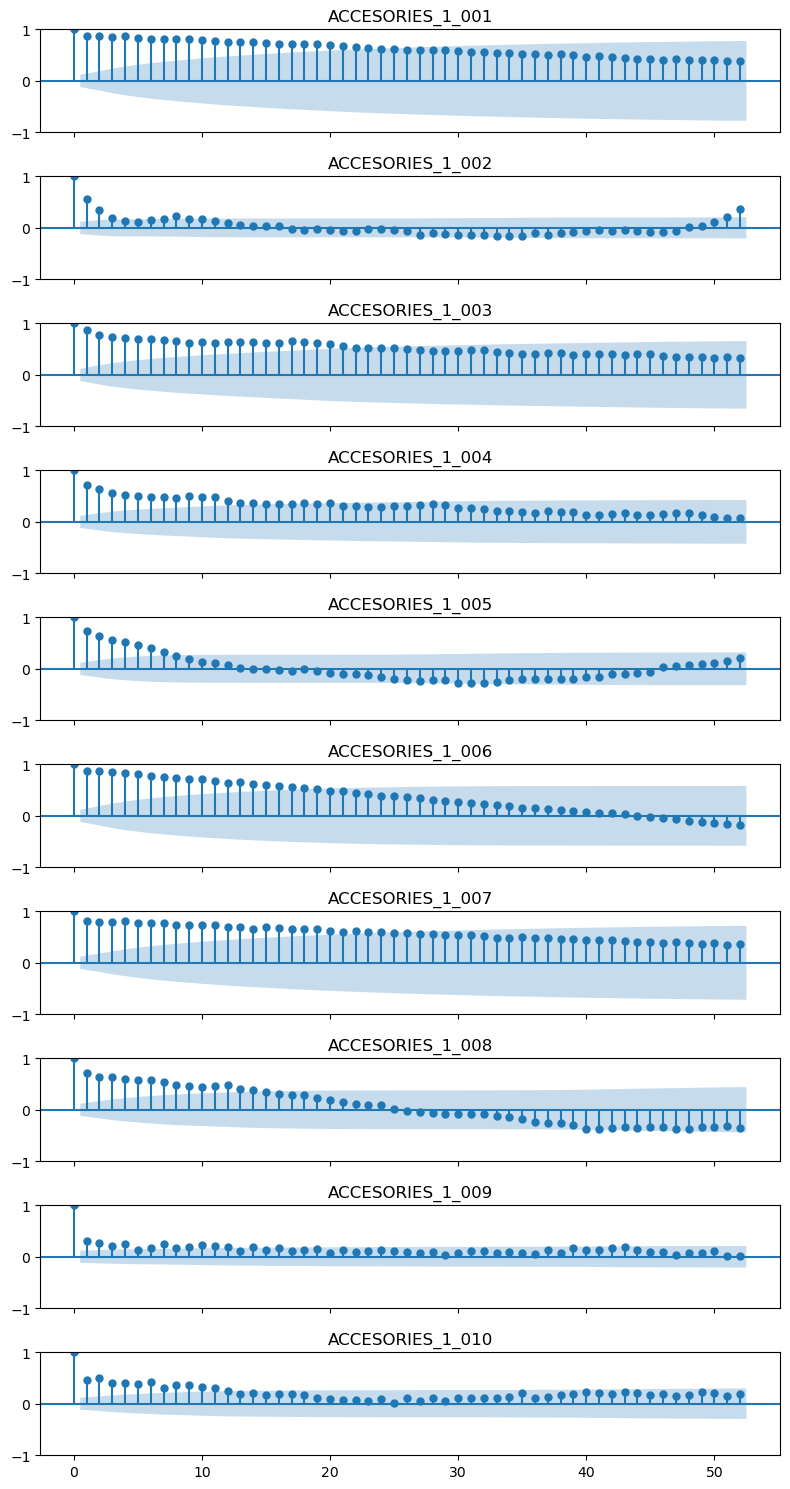

In [12]:
from statsmodels.graphics.tsaplots import plot_acf


fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(8, 15), sharex=True)
axes = axes.flat
for i, col in enumerate(df_productos_multi.columns[:10]):
    plot_acf(df_productos_multi[col], ax=axes[i], lags=52)
    axes[i].set_title(f'{col}')
fig.tight_layout()
plt.show()

In [16]:
items = list(df_productos_multi.columns)

# Definir el forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = XGBRegressor(random_state=123),
                    lags               = 12,
                    transformer_series = StandardScaler()
                )

# Backtesting forecaster para todos los items
multi_series_mae_xgb, predictions_ms_xgb = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = df_productos_multi,
                                       levels             = items,
                                       steps              = 5,
                                       metric             = ['mean_squared_error', 'mean_absolute_error',"mean_absolute_percentage_error"],
                                       initial_train_size = len(data_train) + len(data_val),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True,
                                       random_state       = 123
                                   )

# Resultados

display(multi_series_mae_xgb.head(3))
print('')
display(predictions_ms_xgb.head(3))

  0%|          | 0/10 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,ACCESORIES_1_001,13947.775033,100.050033,3.386724e-01
1,ACCESORIES_1_002,1988.653411,26.537267,3.452467e-01
2,ACCESORIES_1_003,874.058371,20.847907,6.290407e+15


,ACCESORIES_1_001,ACCESORIES_1_002,ACCESORIES_1_003,ACCESORIES_1_004,ACCESORIES_1_005,ACCESORIES_1_006,ACCESORIES_1_007,ACCESORIES_1_008,ACCESORIES_1_009,ACCESORIES_1_010,...,SUPERMARKET_3_818,SUPERMARKET_3_819,SUPERMARKET_3_820,SUPERMARKET_3_821,SUPERMARKET_3_822,SUPERMARKET_3_823,SUPERMARKET_3_824,SUPERMARKET_3_825,SUPERMARKET_3_826,SUPERMARKET_3_827
2015-05-24,284.715768,83.915746,55.905599,1000.802938,161.578390,72.736419,118.251326,199.138447,119.240083,141.181600,...,648.865069,255.693817,291.102406,247.641902,589.381184,301.117054,27.429614,313.046583,129.738862,136.538384
2015-05-31,328.024332,82.576900,56.211999,992.825540,169.840906,75.504964,140.771851,207.480623,140.294644,146.977252,...,640.496947,237.421131,293.995812,249.210126,640.335264,289.774469,28.641214,295.998018,130.486506,133.240193
2015-06-07,312.312765,87.375312,59.241453,991.671065,173.024540,76.305969,143.989308,219.393756,122.038289,150.352829,...,693.535211,250.684961,310.227773,263.781576,715.018739,303.057967,32.603827,297.867945,127.306195,132.168907


In [16]:
predictions_ms.head()

,ACCESORIES_1_001,ACCESORIES_1_002,ACCESORIES_1_003,ACCESORIES_1_004,ACCESORIES_1_005,ACCESORIES_1_006,ACCESORIES_1_007,ACCESORIES_1_008,ACCESORIES_1_009,ACCESORIES_1_010,...,SUPERMARKET_3_818,SUPERMARKET_3_819,SUPERMARKET_3_820,SUPERMARKET_3_821,SUPERMARKET_3_822,SUPERMARKET_3_823,SUPERMARKET_3_824,SUPERMARKET_3_825,SUPERMARKET_3_826,SUPERMARKET_3_827
2015-05-24,284.715768,83.915746,55.905599,1000.802938,161.578390,72.736419,118.251326,199.138447,119.240083,141.181600,...,648.865069,255.693817,291.102406,247.641902,589.381184,301.117054,27.429614,313.046583,129.738862,136.538384
2015-05-31,328.024332,82.576900,56.211999,992.825540,169.840906,75.504964,140.771851,207.480623,140.294644,146.977252,...,640.496947,237.421131,293.995812,249.210126,640.335264,289.774469,28.641214,295.998018,130.486506,133.240193
2015-06-07,312.312765,87.375312,59.241453,991.671065,173.024540,76.305969,143.989308,219.393756,122.038289,150.352829,...,693.535211,250.684961,310.227773,263.781576,715.018739,303.057967,32.603827,297.867945,127.306195,132.168907
2015-06-14,288.030733,89.066311,59.250437,999.778478,167.955580,72.967125,138.852827,217.758743,124.086129,152.788098,...,683.910008,266.327485,307.457101,259.077108,621.062812,308.269111,37.714937,321.537471,131.041746,145.125540
2015-06-21,289.308923,93.507810,55.567829,996.585510,169.600301,70.176272,132.951898,208.989952,122.933898,148.509542,...,656.937252,258.621138,304.949780,259.090690,661.053347,297.368281,38.082146,340.276818,135.148565,150.118860


In [18]:
display(multi_series_mae.head(5))
multi_series_mae.tail(5)

,levels,mean_absolute_error
0,ACCESORIES_1_001,124.284954
1,ACCESORIES_1_002,32.439121
2,ACCESORIES_1_003,25.815884
3,ACCESORIES_1_004,149.695597
4,ACCESORIES_1_005,59.569336


,levels,mean_absolute_error
3044,SUPERMARKET_3_823,90.244861
3045,SUPERMARKET_3_824,38.200176
3046,SUPERMARKET_3_825,88.792381
3047,SUPERMARKET_3_826,34.442871
3048,SUPERMARKET_3_827,60.375469


In [17]:
items = list(df_productos_multi.columns)

# Definir el forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = CatBoostRegressor(random_state=123),
                    lags               = 12,
                    transformer_series = StandardScaler()
                )

# Backtesting forecaster para todos los items
multi_series_mae_catb, predictions_ms_catb = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = df_productos_multi,
                                       levels             = items,
                                       steps              = 5,
                                       metric             = ['mean_squared_error', 'mean_absolute_error',"mean_absolute_percentage_error"],
                                       initial_train_size = len(data_train) + len(data_val),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True,
                                       random_state       = 123
                                   )

# Resultados

display(multi_series_mae_catb.head(3))
print('')
display(predictions_ms_catb.head(3))

Learning rate set to 0.113825
0:	learn: 0.9253389	total: 200ms	remaining: 3m 19s
1:	learn: 0.8729201	total: 252ms	remaining: 2m 5s
2:	learn: 0.8290955	total: 328ms	remaining: 1m 48s
3:	learn: 0.7921483	total: 405ms	remaining: 1m 40s
4:	learn: 0.7602882	total: 601ms	remaining: 1m 59s
5:	learn: 0.7340536	total: 721ms	remaining: 1m 59s
6:	learn: 0.7121842	total: 822ms	remaining: 1m 56s
7:	learn: 0.6936282	total: 905ms	remaining: 1m 52s
8:	learn: 0.6784777	total: 1s	remaining: 1m 50s
9:	learn: 0.6658727	total: 1.07s	remaining: 1m 46s
10:	learn: 0.6552035	total: 1.14s	remaining: 1m 42s
11:	learn: 0.6465483	total: 1.2s	remaining: 1m 39s
12:	learn: 0.6393173	total: 1.28s	remaining: 1m 36s
13:	learn: 0.6334182	total: 1.34s	remaining: 1m 34s
14:	learn: 0.6284075	total: 1.42s	remaining: 1m 33s
15:	learn: 0.6243134	total: 1.52s	remaining: 1m 33s
16:	learn: 0.6210124	total: 1.61s	remaining: 1m 32s
17:	learn: 0.6181975	total: 1.73s	remaining: 1m 34s
18:	learn: 0.6156593	total: 1.8s	remaining: 1m 33

  0%|          | 0/10 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,ACCESORIES_1_001,14172.142974,100.728023,3.353572e-01
1,ACCESORIES_1_002,1902.053707,25.584560,3.374695e-01
2,ACCESORIES_1_003,997.446623,22.604840,5.897971e+15


,ACCESORIES_1_001,ACCESORIES_1_002,ACCESORIES_1_003,ACCESORIES_1_004,ACCESORIES_1_005,ACCESORIES_1_006,ACCESORIES_1_007,ACCESORIES_1_008,ACCESORIES_1_009,ACCESORIES_1_010,...,SUPERMARKET_3_818,SUPERMARKET_3_819,SUPERMARKET_3_820,SUPERMARKET_3_821,SUPERMARKET_3_822,SUPERMARKET_3_823,SUPERMARKET_3_824,SUPERMARKET_3_825,SUPERMARKET_3_826,SUPERMARKET_3_827
2015-05-24,288.584983,85.770916,54.539097,990.313227,158.729302,70.010937,125.780359,203.118799,120.290218,135.572666,...,632.491148,234.242069,297.709871,242.883012,561.014554,309.182120,31.762445,325.583734,123.193157,129.947855
2015-05-31,324.375545,83.326825,48.716977,981.483597,165.109643,77.528958,141.733710,209.223494,125.390017,139.176721,...,634.747742,236.919072,293.374867,242.190849,659.315282,289.531732,33.416477,300.413412,125.794618,123.667037
2015-06-07,319.789327,83.237446,52.067610,980.010144,169.286807,78.638555,143.578104,219.048172,123.875177,139.288082,...,665.630256,249.495847,303.037627,252.542850,664.781135,294.162047,39.960813,303.341416,121.076229,117.869020


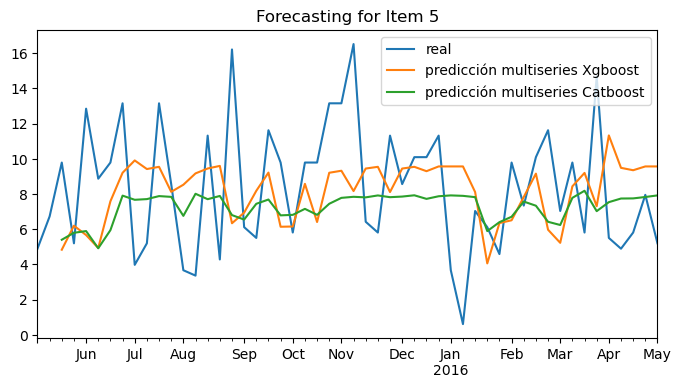

In [18]:
fig, ax=plt.subplots(figsize=(8, 4))
data_test['ACCESORIES_2_026'].tail(100).plot(ax=ax)
predictions_ms_xgb['ACCESORIES_2_026'].tail(100).plot(ax=ax)
predictions_ms_catb['ACCESORIES_2_026'].tail(100).plot(ax=ax)
ax.legend(['real', 'predicción multiseries Xgboost', 'predicción multiseries Catboost'])
ax.set_xlabel('')
ax.set_title('Forecasting for Item 5');

In [22]:
pipeline = make_pipeline(TimeSeriesDifferentiator(order=1),StandardScaler())
pipeline

Pipeline(steps=[('timeseriesdifferentiator', TimeSeriesDifferentiator()),
                ('standardscaler', StandardScaler())])

In [23]:
items = list(df_productos_multi.columns)

# Definir el forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = XGBRegressor(random_state=123),
                    lags               = 12,
                    transformer_exog   = pipeline,
                )

# Backtesting forecaster para todos los items
multi_series_mae_xgb_dif, predictions_ms_xgb_dif = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = df_productos_multi,
                                       levels             = items,
                                       steps              = 5,
                                       metric             = ['mean_squared_error', 'mean_absolute_error',"mean_absolute_percentage_error"],
                                       initial_train_size = len(data_train) + len(data_val),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True,
                                       random_state       = 123
                                   )


# Resultados
display(multi_series_mae_xgb_dif.head(3))
print('')
display(predictions_ms_xgb_dif.head(3))

  0%|          | 0/10 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,ACCESORIES_1_001,11990.608929,87.653845,3.311155e-01
1,ACCESORIES_1_002,2006.695323,30.416828,3.939213e-01
2,ACCESORIES_1_003,792.561853,19.184946,9.177946e+15


,ACCESORIES_1_001,ACCESORIES_1_002,ACCESORIES_1_003,ACCESORIES_1_004,ACCESORIES_1_005,ACCESORIES_1_006,ACCESORIES_1_007,ACCESORIES_1_008,ACCESORIES_1_009,ACCESORIES_1_010,...,SUPERMARKET_3_818,SUPERMARKET_3_819,SUPERMARKET_3_820,SUPERMARKET_3_821,SUPERMARKET_3_822,SUPERMARKET_3_823,SUPERMARKET_3_824,SUPERMARKET_3_825,SUPERMARKET_3_826,SUPERMARKET_3_827
2015-05-24,307.823639,75.832809,65.974144,953.316833,168.067993,71.699966,146.325638,207.520508,112.656921,120.633461,...,636.005798,216.218063,280.576599,245.406998,384.870331,305.817474,26.487846,340.699829,130.983566,147.282623
2015-05-31,333.500610,75.343849,65.974144,955.227051,171.551239,68.992188,151.675064,208.172729,107.718956,125.201477,...,638.266846,200.889954,274.423462,234.320465,561.121399,290.922424,26.487846,308.038269,121.983879,145.849152
2015-06-07,326.385590,69.618034,65.974144,963.768555,160.293152,78.843849,152.175949,204.114655,109.671082,123.761986,...,688.281616,221.676468,299.982666,253.282578,590.769043,285.377106,31.921646,302.904236,122.303673,150.553680


In [24]:
items = list(df_productos_multi.columns)

# Definir el forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = CatBoostRegressor(random_state=123),
                    lags               = 12,
                    transformer_exog   = pipeline,
                )

# Backtesting forecaster para todos los items
multi_series_mae_cat_dif, predictions_ms_cat_dif = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = df_productos_multi,
                                       levels             = items,
                                       steps              = 5,
                                       metric             = ['mean_squared_error', 'mean_absolute_error',"mean_absolute_percentage_error"],
                                       initial_train_size = len(data_train) + len(data_val),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True,
                                       random_state       = 123
                                   )


# Resultados
display(multi_series_mae_cat_dif.head(3))
print('')
display(predictions_ms_cat_dif.head(3))

Learning rate set to 0.113825
0:	learn: 455.0695331	total: 199ms	remaining: 3m 19s
1:	learn: 413.2530848	total: 256ms	remaining: 2m 7s
2:	learn: 376.5706700	total: 349ms	remaining: 1m 55s
3:	learn: 344.5461715	total: 430ms	remaining: 1m 47s
4:	learn: 317.0623318	total: 499ms	remaining: 1m 39s
5:	learn: 292.7064141	total: 563ms	remaining: 1m 33s
6:	learn: 271.4118373	total: 629ms	remaining: 1m 29s
7:	learn: 253.3870679	total: 703ms	remaining: 1m 27s
8:	learn: 237.7413898	total: 773ms	remaining: 1m 25s
9:	learn: 224.8098430	total: 854ms	remaining: 1m 24s
10:	learn: 213.6972318	total: 926ms	remaining: 1m 23s
11:	learn: 204.3730487	total: 991ms	remaining: 1m 21s
12:	learn: 196.4295417	total: 1.06s	remaining: 1m 20s
13:	learn: 189.6061300	total: 1.14s	remaining: 1m 20s
14:	learn: 183.7145044	total: 1.21s	remaining: 1m 19s
15:	learn: 178.7500602	total: 1.28s	remaining: 1m 18s
16:	learn: 174.5333179	total: 1.35s	remaining: 1m 17s
17:	learn: 170.9007140	total: 1.43s	remaining: 1m 18s
18:	learn

  0%|          | 0/10 [00:00<?, ?it/s]

,levels,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,ACCESORIES_1_001,11820.299586,87.262242,3.244657e-01
1,ACCESORIES_1_002,1914.528899,27.417414,3.601375e-01
2,ACCESORIES_1_003,926.359383,21.655425,9.477254e+15


,ACCESORIES_1_001,ACCESORIES_1_002,ACCESORIES_1_003,ACCESORIES_1_004,ACCESORIES_1_005,ACCESORIES_1_006,ACCESORIES_1_007,ACCESORIES_1_008,ACCESORIES_1_009,ACCESORIES_1_010,...,SUPERMARKET_3_818,SUPERMARKET_3_819,SUPERMARKET_3_820,SUPERMARKET_3_821,SUPERMARKET_3_822,SUPERMARKET_3_823,SUPERMARKET_3_824,SUPERMARKET_3_825,SUPERMARKET_3_826,SUPERMARKET_3_827
2015-05-24,303.564983,83.596459,59.721674,939.397826,163.945078,82.026526,142.719127,206.415537,115.346229,125.673692,...,685.165442,223.784224,285.400258,259.995649,331.063009,303.905801,28.570296,325.209943,127.316035,154.933708
2015-05-31,307.770555,83.147753,59.468598,936.521386,172.828715,71.049448,151.075833,204.957555,115.999324,124.638848,...,660.956637,207.999087,282.116590,253.858138,456.453305,289.878768,34.269564,310.513132,130.404758,156.113013
2015-06-07,318.568197,84.178785,60.812080,947.482927,164.502226,83.680402,146.191785,200.351010,108.228533,122.740547,...,710.187398,232.095250,292.050648,264.531894,548.463476,288.214969,35.719917,314.175695,128.596136,156.095613


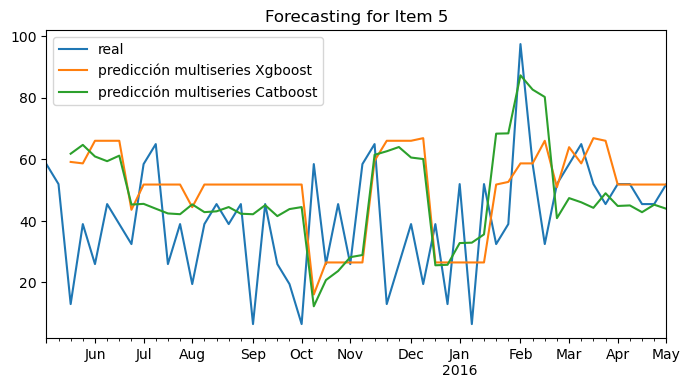

In [39]:
fig, ax=plt.subplots(figsize=(8, 4))
data_test['ACCESORIES_1_065'].tail(200).plot(ax=ax)
predictions_ms_xgb_dif['ACCESORIES_1_065'].tail(200).plot(ax=ax)
predictions_ms_cat_dif['ACCESORIES_1_065'].tail(200).plot(ax=ax)
ax.legend(['real', 'predicción multiseries Xgboost', 'predicción multiseries Catboost'])
ax.set_xlabel('')
ax.set_title('Forecasting for Item 5');

In [32]:
# Suponiendo que tienes cuatro conjuntos de datos llamados multi_series_mae_xgb, 
# multi_series_mae_rf, multi_series_mae_svm y multi_series_mae_lr, cada uno siendo un DataFrame de Pandas
# con columnas "mean_squared_error", "mean_absolute_error" y "mean_absolute_percentage_error"

# Definir los nombres de los modelos
nombres_modelos = ["XGBoost", "CatBoost", "XGBoost Diferenciado", "CatBoost Diferenciado"]

# Lista para almacenar los resultados de cada modelo
resultados = []

# Iterar sobre cada modelo
for modelo, nombre_modelo in zip([multi_series_mae_xgb, multi_series_mae_catb, multi_series_mae_xgb_dif, multi_series_mae_cat_dif], nombres_modelos):
    # Calcular las métricas promedio para el modelo actual
    mse_promedio = modelo["mean_squared_error"].sum() / len(modelo)
    mae_promedio = modelo["mean_absolute_error"].sum() / len(modelo)
    mape_promedio = modelo["mean_absolute_percentage_error"].sum() / len(modelo)
    
    # Almacenar los resultados en la lista de resultados
    resultados.append([nombre_modelo, mse_promedio, mae_promedio, mape_promedio])

# Crear un DataFrame con los resultados
model_errors  = pd.DataFrame(resultados, columns=["Modelo", "Mean Squared Error", "Mean Absolute Error", "Mean Absolute Percentage Error"])

In [33]:
model_errors

,Modelo,Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error
0,XGBoost,52592.184251,86.480615,2.255939e+16
1,CatBoost,50734.521293,86.380633,2.332394e+16
2,XGBoost Diferenciado,55343.967305,84.624506,2.181140e+16
3,CatBoost Diferenciado,56856.209330,84.419670,2.489260e+16


In [62]:
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = CatBoostRegressor(random_state=123),
                 lags               = 12,
                 transformer_exog   = pipeline,
                 weight_func        = None,
                 series_weights     = None
             )

In [63]:
forecaster.fit(df_productos_multi)

Learning rate set to 0.117698
0:	learn: 476.8536233	total: 280ms	remaining: 4m 39s
1:	learn: 434.3054089	total: 337ms	remaining: 2m 48s
2:	learn: 396.7538332	total: 396ms	remaining: 2m 11s
3:	learn: 364.3786125	total: 449ms	remaining: 1m 51s
4:	learn: 336.1556397	total: 518ms	remaining: 1m 43s
5:	learn: 311.8085466	total: 583ms	remaining: 1m 36s
6:	learn: 290.2812645	total: 632ms	remaining: 1m 29s
7:	learn: 272.0639115	total: 680ms	remaining: 1m 24s
8:	learn: 256.2393127	total: 737ms	remaining: 1m 21s
9:	learn: 242.9938406	total: 801ms	remaining: 1m 19s
10:	learn: 231.3948620	total: 846ms	remaining: 1m 16s
11:	learn: 221.7769964	total: 892ms	remaining: 1m 13s
12:	learn: 213.3394263	total: 943ms	remaining: 1m 11s
13:	learn: 206.1664253	total: 1.02s	remaining: 1m 11s
14:	learn: 199.9203688	total: 1.06s	remaining: 1m 9s
15:	learn: 194.5601399	total: 1.11s	remaining: 1m 8s
16:	learn: 190.0755153	total: 1.17s	remaining: 1m 7s
17:	learn: 186.2183954	total: 1.22s	remaining: 1m 6s
18:	learn: 1

In [64]:
forecasting_prediction_8= forecaster.predict(steps=8)

In [124]:
def producto_predict_plot(columna):
    fig, ax=plt.subplots(figsize=(8, 4))
    data_test[columna].tail(200).plot(ax=ax)
    forecasting_prediction_8[columna].tail(200).plot(ax=ax)
    predictions_ms_cat_dif[columna].tail(200).plot(ax=ax)
    ax.legend(['real', 'predicción multiseries Xgboost', 'predicción multiseries Catboost'])
    ax.set_xlabel('')
    ax.set_title(f'Forecasting for {columna}');

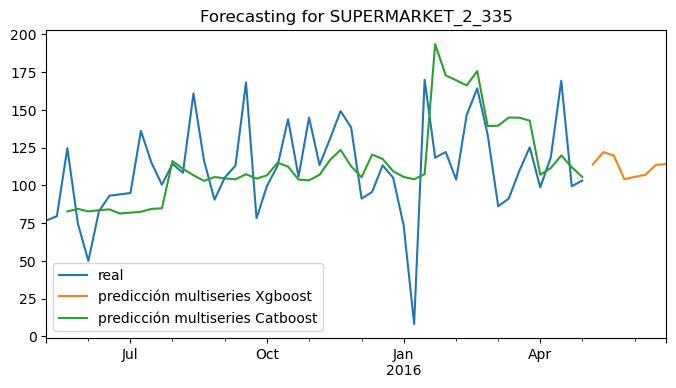

In [119]:
# Lista de nombres de columnas comunes
column_names = df_productos_multi.columns

# Selecciona una columna aleatoria
random_column = random.choice(column_names)

producto_predict_plot(random_column)

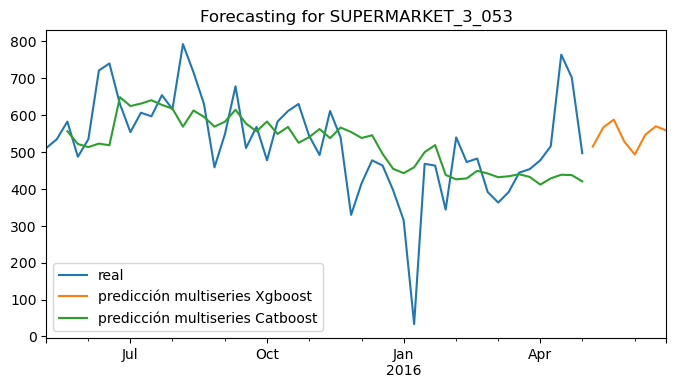

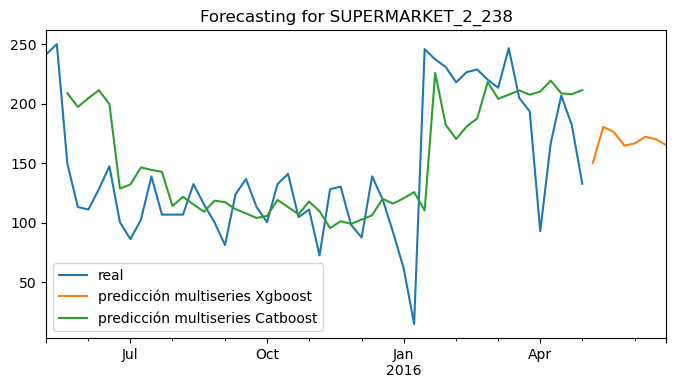

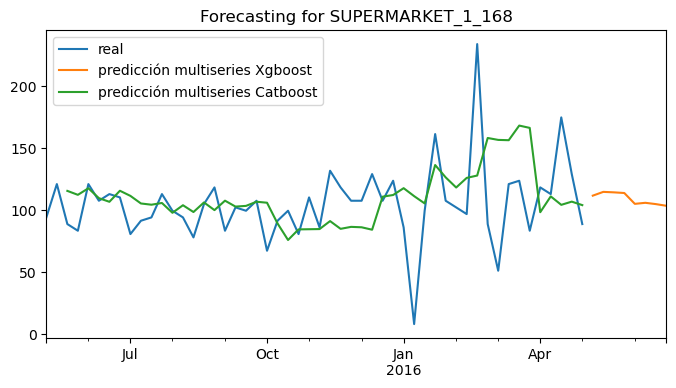

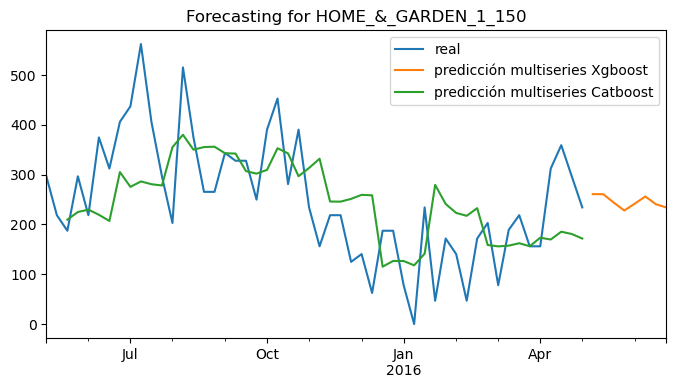

In [125]:
# Convertir las columnas en una list
columnas = list(df_productos_multi.columns)

# Seleccionar cuatro columnas aleatorias
columnas_seleccionadas = random.sample(columnas, 4)

# Crear un gráfico para cada columna seleccionada
for columna in columnas_seleccionadas:
    producto_predict_plot(columna)


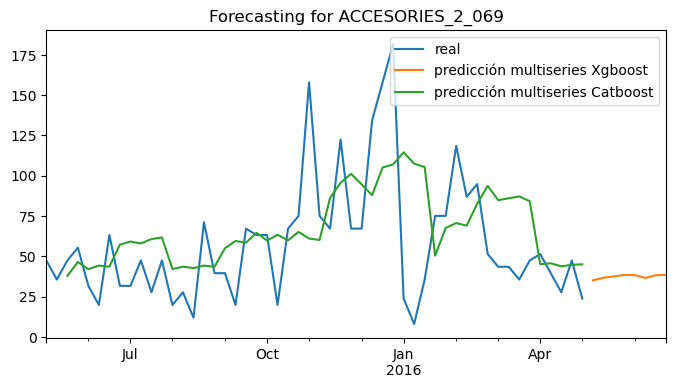

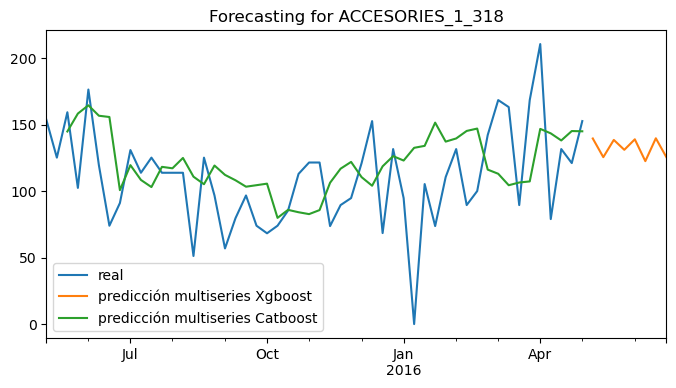

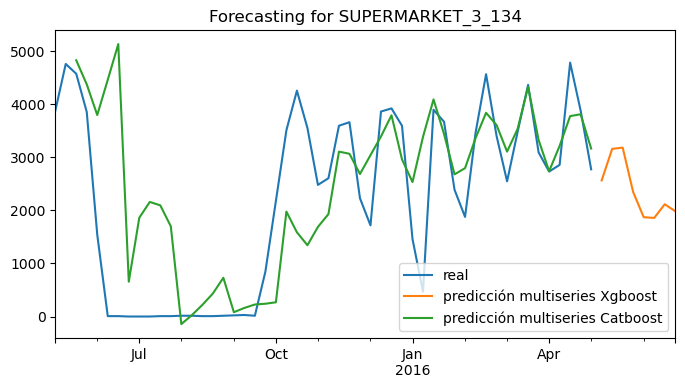

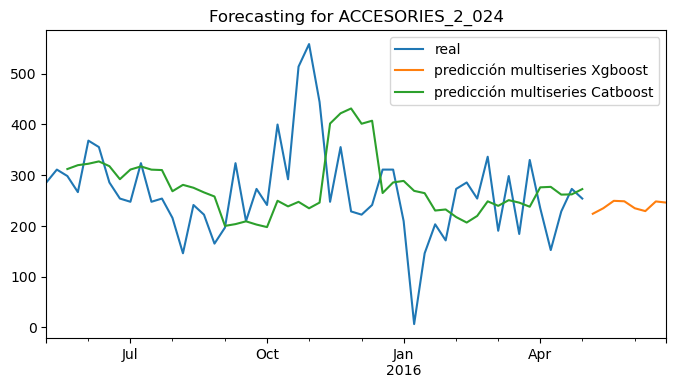

In [123]:
# Convertir las columnas en una list
columnas = list(df_productos_multi.columns)

# Seleccionar cuatro columnas aleatorias
columnas_seleccionadas = random.sample(columnas, 4)

# Crear un gráfico para cada columna seleccionada
for columna in columnas_seleccionadas:
    producto_predict_plot(columna)